In [11]:
from scipy.stats import multivariate_normal, norm
import numpy as np

import pickle

from conditional_inference.bayes.classic_bayes import LinearClassicBayes
from conditional_inference.bayes.empirical_bayes import LinearEmpiricalBayes, JamesStein
from conditional_inference.bayes.hierarchical_bayes import LinearHierarchicalBayes

mean = np.arange(4)
# cov = .1 * np.diag([1, 2, 3])
cov = .1 * np.identity(4)
model = LinearClassicBayes(mean, cov, prior_cov=1)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
  Classical Bayes estimates  
=============================
    coef pvalue [0.025 0.975]
-----------------------------
x0 0.136  0.328 -0.462  0.735
x1 1.045  0.000  0.447  1.644
x2 1.955  0.000  1.356  2.553
x3 2.864  0.000  2.265  3.462
===============
Dep. Variable y
---------------
"""

In [30]:
import numpy as np
from conditional_inference.bayes.hierarchical_bayes import LinearHierarchicalBayes
from scipy.stats import multivariate_normal, loguniform
n_policies = 5
prior_cov_params_distribution = loguniform(.1, 10)
prior_cov = prior_cov_params_distribution.rvs() * np.identity(n_policies)
prior_mean = np.zeros(n_policies)
true_mean = multivariate_normal(prior_mean, prior_cov).rvs()
sample_cov = np.identity(n_policies)
sample_mean = multivariate_normal(true_mean, sample_cov).rvs()
model = LinearHierarchicalBayes(sample_mean, sample_cov, prior_cov_params_distribution)
print(model.fit(cols="sorted").summary())

 Hierarchical Bayes estimates 
    coef  pvalue [0.025 0.975]
------------------------------
x0  1.545  0.041 -0.165  3.531
x1  0.413  0.348 -1.478  2.317
x2  0.041  0.479 -1.961  2.024
x4 -1.200  0.900 -2.940  0.673
x3 -3.772  1.000 -5.828 -1.620
Dep. Variable y
---------------


In [31]:
true_mean[(-sample_mean).argsort()]

array([ 0.85435414, -0.19601094, -0.03261528, -1.39485556, -3.92410774])

In [32]:
sample_mean[(-sample_mean).argsort()]

array([ 2.07998495,  0.70282072,  0.26127021, -1.32947164, -4.58526143])

<AxesSubplot:title={'center':'Classical Bayes estimates'}, ylabel='Rank'>

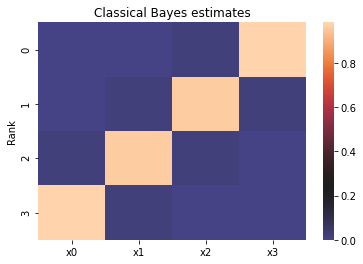

In [12]:
res.rank_matrix_plot()

In [8]:
from conditional_inference.base import ModelBase

import numpy as np
import statsmodels.api as sm

X = np.repeat(np.identity(3), 100, axis=0)
beta = np.array([0, 1, 2])
y = X @ beta + np.random.normal(size=300)
ols_results = sm.OLS(y, X).fit()
model = ModelBase.from_results(ols_results)
model.mean
# model = ModelBase([1, 2, 3], np.identity(3))
# model.mean

array([-0.20434022,  0.96700821,  1.88196662])

In [9]:
model.cov

array([[0.01163716, 0.        , 0.        ],
       [0.        , 0.01163716, 0.        ],
       [0.        , 0.        , 0.01163716]])

<AxesSubplot:title={'center':'Classical Bayes estimates'}, xlabel='y'>

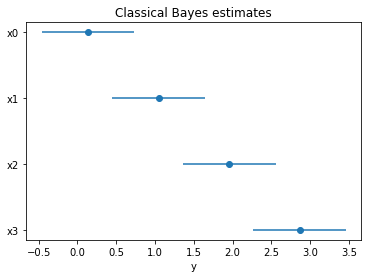

In [2]:
res.point_plot()

In [10]:
res.rank_matrix_plot()

NameError: name 'res' is not defined

In [3]:
res = JamesStein(mean, cov).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
  Empirical Bayes estimates  
=============================
    coef pvalue [0.025 0.975]
-----------------------------
x0 0.030  0.462 -0.591  0.651
x1 1.010  0.001  0.394  1.626
x2 1.990  0.000  1.374  2.606
x3 2.970  0.000  2.349  3.591
===============
Dep. Variable y
---------------
"""

<AxesSubplot:title={'center':'Empirical Bayes estimates'}, xlabel='y'>

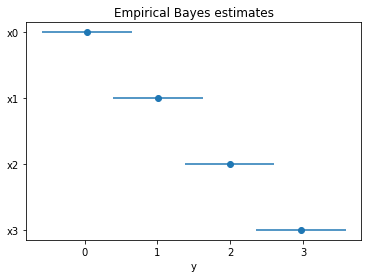

In [4]:
res.point_plot()

In [5]:
from scipy.stats import loguniform

res = LinearHierarchicalBayes(mean, cov, prior_cov_params_distribution=loguniform(1e-3, 1e3)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
 Hierarchical Bayes estimates
=============================
    coef pvalue [0.025 0.975]
-----------------------------
x0 0.120  0.383 -0.548  0.769
x1 1.037  0.000  0.429  1.667
x2 1.963  0.000  1.299  2.571
x3 2.924  0.000  2.401  3.596
===============
Dep. Variable y
---------------
"""

In [6]:
res.point_plot()

<AxesSubplot:title={'center':'Hierarchical Bayes estimates'}, xlabel='y'>

In [28]:
import scipy

class Request:
    param = 5, loguniform(1e-1, 1e1)

def make_simulation_params(request, n_simulations, homoskedastic=False):
    def make_params():
        true_mean = multivariate_normal(prior_mean, sample_prior_cov()).rvs()
        if homoskedastic:
            cov = np.identity(n_policies)
        else:
            cov = np.diag(np.random.uniform(1, 2, size=n_policies))
        sample_mean = multivariate_normal(true_mean, cov).rvs()
        return true_mean, sample_mean, cov

    def sample_prior_cov():
        if hasattr(prior_cov, "rvs"):
            # prior_cov is a distribution
            return prior_cov.rvs() * np.identity(n_policies)
        else:
            return prior_cov

    n_policies, prior_cov = request.param
    prior_mean = np.zeros(n_policies)
    if np.isscalar(prior_cov):
        prior_cov = prior_cov * np.identity(n_policies)
    true_means, sample_means, covs = zip(*[make_params() for _ in range(n_simulations)])
    return prior_cov, np.array(true_means), np.array(sample_means), np.array(covs)

request = Request()
n_simulations = 2**7

simulation_params = make_simulation_params(request, n_simulations)

In [29]:
def get_results(model_cls, simulation_params, **kwargs):
    sample_means, covs = simulation_params[2:]
    results = []
    for sample_mean, cov in zip(sample_means, covs):
        model = model_cls(sample_mean, cov, **kwargs)
        results.append(model.fit())
    return results
    
results = get_results(LinearHierarchicalBayes, simulation_params, prior_cov_params_distribution=loguniform(1e-1, 1e1))
results[0].point_plot()

<AxesSubplot:title={'center':'Hierarchical Bayes estimates'}, xlabel='y'>

In [30]:
def run_conf_int(results, simulation_params, alphas=(0.01, 0.05, 0.1)):
    true_means = simulation_params[1]
    for alpha in alphas:
        conf_int = np.array([result.conf_int(alpha=alpha) for result in results])
        observed_alpha = (
            (true_means < conf_int[:, :, 0]) | (conf_int[:, :, 1] < true_means)
        ).mean()
        print(alpha, observed_alpha)
        # logger.info(f"{1-alpha} CI coverage: {1-observed_alpha}")
        # _, upper_bound = get_bounds(true_means.size, alpha)
        # assert observed_alpha <= upper_bound

run_conf_int(results, simulation_params)

0.01 0.0
0.05 0.0375
0.1 0.1


In [31]:
def run_pvalues(results, simulation_params, alphas=(0.01, 0.05, 0.1)):
    true_means = simulation_params[1]
    true_mean_lt_0 = true_means < 0
    pvalues = np.array([result.pvalues for result in results])
    pvalues = pvalues[true_mean_lt_0]
    for alpha in alphas:
        fp_rate = (pvalues < alpha).sum() / true_mean_lt_0.sum()
        print(fp_rate)
        # logger.info(f"FP rate for alpha={alpha}: {fp_rate:.3f}")
        # _, upper_bound = get_bounds(pvalues.size, alpha)
        # assert fp_rate <= upper_bound

run_pvalues(results, simulation_params)

0.0
0.045454545454545456
0.06818181818181818


In [31]:
def run_simulation(n_policies=5, prior_cov=10):
    prior_mean = np.zeros(n_policies)
    prior_cov = prior_cov * np.identity(n_policies)
    true_mean = multivariate_normal(prior_mean, prior_cov).rvs()
    # cov = np.diag(np.random.uniform(1, 2, size=n_policies))
    cov = np.random.uniform(1, 2) * np.identity(n_policies)
    sample_mean = multivariate_normal(true_mean, cov).rvs()
    # model = LinearEmpiricalBayes(sample_mean, cov)
    model = JamesStein(sample_mean, cov)
    res = model.fit()
    conf_int = res.conf_int(.1)
    return (conf_int[:, 0] <= true_mean) & (true_mean <= conf_int[:, 1])

results = np.array([run_simulation() for _ in range(100)])
results.mean()

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\bayes\empirical_bayes.py:184: RuntimeWarning: The prior variance parameter given by the James-Stein estimator 0.34641863565011605 implies the prior covariance matrix is not positive semi-definite. Increasing the prior variance parameter to 1.0459651947021484.
  warnings.warn(
c:\users\dbspe\repos\ordered-inference\src\conditional_inference\bayes\empirical_bayes.py:184: RuntimeWarning: The prior variance parameter given by the James-Stein estimator 0.9914445321169499 implies the prior covariance matrix is not positive semi-definite. Increasing the prior variance parameter to 1.0145931243896484.
  warnings.warn(
c:\users\dbspe\repos\ordered-inference\src\conditional_inference\bayes\empirical_bayes.py:184: RuntimeWarning: The prior variance parameter given by the James-Stein estimator 1.2458928570334593 implies the prior covariance matrix is not positive semi-definite. Increasing the prior variance parameter to 1.48647308349

0.888

In [29]:
def bayes_results(request, n_simulations=10):
    def get_results():
        true_mean = multivariate_normal(prior_mean, prior_cov).rvs()
        cov = np.diag(np.random.uniform(0, 1, size=n_policies))
        sample_mean = multivariate_normal(true_mean, cov).rvs()
        model = ClassicLinearBayes(sample_mean, cov, prior_cov=prior_cov)
        return true_mean, model.fit()

    n_policies, prior_cov = request
    prior_mean = np.zeros(n_policies)
    prior_cov = prior_cov * np.identity(n_policies)
    true_means, results = zip(*[get_results() for _ in range(n_simulations)])
    return np.array(true_means), results

results = bayes_results((5, 10))
true_means, results = results
true_means.shape

(10, 5)

In [42]:
x = [1, 2, 3]
x[0, 2]

TypeError: list indices must be integers or slices, not tuple

In [39]:
pvalues = np.array([result.pvalues for result in results])
true_effect_lt_0 = true_means < 0
fp = pvalues[true_effect_lt_0] < .05
fpr = fp.sum() / true_effect_lt_0.sum()
fpr

0.0

In [41]:
pvalues[true_effect_lt_0]

array([0.95833605, 0.99739477, 0.94023438, 0.99999977, 1.        ,
       0.99999966, 0.83011114, 0.49892976, 0.5360661 , 0.99996897,
       0.9999992 , 0.99999992, 1.        , 0.97726254, 0.9985098 ,
       1.        , 0.99825563, 1.        , 0.99999998, 1.        ,
       0.99759019, 0.19971726, 0.97157145, 0.9652935 ])

In [23]:
true_means.size

50

In [6]:
from scipy.stats import norm, multivariate_normal

multivariate_normal([0, 1], np.array([[0, 0], [0, 0]]))

LinAlgError: singular matrix

<AxesSubplot:title={'center':'Classical Bayesian estimates'}, xlabel='y'>

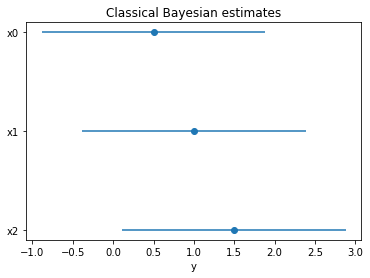

In [3]:
model = ClassicLinearBayes(mean, cov, prior_cov=1)
model.fit().point_plot()

In [4]:
model = ClassicLinearBayes(mean, cov, prior_cov=10)
model.fit().point_plot()

<AxesSubplot:title={'center':'Classical Bayesian estimates'}, xlabel='y'>

In [2]:
from conditional_inference.quantile_unbiased.rqu import RQU

npolicies = 5
mean = np.random.normal(size=npolicies)
cov = np.identity(npolicies)
rqu = RQU(mean, cov)
results = rqu.fit(cols="sorted", beta=.005)
print(results.summary())

beta is 0
beta is 0
beta is 0
beta is 0
beta is 0
c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased\stats.py:81: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
     Quantile-unbiased estimates     
   coef (median) pvalue [0.025 0.975]
-------------------------------------
x3         0.326  0.423 -2.354  2.865
x2         0.335  0.436 -3.059  3.337
x4        -3.467  0.860 -4.360  2.325
x1        -4.260  0.777 -4.435  2.446
x0         2.046  0.120 -2.157  2.222
Dep. Variable y
---------------


In [3]:
results = rqu.fit(cols="sorted")
results.summary()

beta is 0
beta is 0
beta is 0
beta isc:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased\stats.py:102: RuntimeWarning: Truncation set contains none of the distribution; results may be incorrect
  warnings.warn(
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
 0
beta is 0


<class 'statsmodels.iolib.summary.Summary'>
"""
     Quantile-unbiased estimates      
======================================
   coef (median) pvalue  [0.025 0.975]
--------------------------------------
x3         0.325  0.421  -4.163  2.770
x2         0.335  0.433  -3.945  5.140
x4        -3.673  0.859 -12.555  2.653
x1        -9.290  0.775 -26.539 13.755
x0         7.939  0.115  -1.987 39.544
===============
Dep. Variable y
---------------
"""

In [4]:
results.point_plot()

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased\stats.py:81: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<AxesSubplot:title={'center':'Quantile-unbiased estimates'}, xlabel='y'>

In [3]:
res.point_plot()

<AxesSubplot:title={'center':'Condition quantile-unbiased estimates'}, xlabel='y'>

In [4]:
res = RQU(ymean, ycov).fit(projection=True)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Projection estimates                    
=============================================================
   coef (conventional) P(theta<0) 0.95 CI lower 0.95 CI upper
-------------------------------------------------------------
x0               0.000      0.870        -2.434         2.434
x1               1.000      0.397        -1.434         3.434
x2               2.000      0.066        -0.434         4.434
===============
Dep. Variable y
---------------
"""

<AxesSubplot:title={'center':'Projection estimates'}, xlabel='y'>

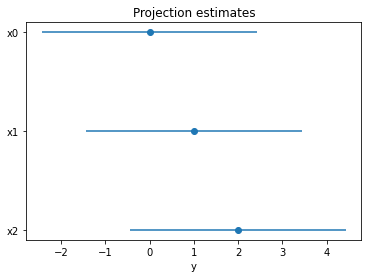

In [5]:
res.point_plot()

In [10]:
def get_results():
    y = norm().rvs(n_policies)
    y = y[(-y).argsort()]
    sigma = np.identity(n_policies)
    return RQU(y, sigma).fit(projection=True)
        
n_simulations = 1000
n_policies = 3
results = [get_results() for _ in range(n_simulations)]

In [11]:
pvalues = np.array([result.pvalues[0] for result in results])
(pvalues < .05).mean()

0.047

In [12]:
import seaborn as sns

sns.histplot(pvalues)

<AxesSubplot:ylabel='Count'>

In [14]:
(pvalues < .5).mean()

0.515

In [16]:
npolicies = 5
mean = np.random.normal(size=npolicies)
cov = np.identity(npolicies)
rqu = RQU(mean, cov)
results = rqu.fit(cols="sorted", projection=True)
print(results.summary())

                     Projection estimates                    
   coef (conventional) P(theta<0) 0.95 CI lower 0.95 CI upper
-------------------------------------------------------------
x0               1.644      0.233        -0.936         4.223
x2               0.813      0.693        -1.766         3.393
x3               0.217      0.931        -2.362         2.796
x1               0.060      0.962        -2.519         2.639
x4              -0.064      0.976        -2.643         2.515
Dep. Variable y
---------------
